This script was used to check the quality of the responses of the online participants. In this analysis, particular attention is given to the catch trials. The performance on the 3 embedded catch trials is then reported per participant and as a summary statistic

Load the data file you want to check. I load here from csv.

In [ ]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file with participants data
df = pd.read_csv('results_with_feedback2.csv')

# Filter for relevant participants (those with non-empty datastring and status=1)
relevant_participants = df[(df['datastring'].notna()) & (df['status'] == 1)]
print(f"Found {len(relevant_participants)} relevant participants")

In [ ]:
relevant_participants

In [ ]:
# Load the conversation labels
df_labels = pd.read_excel('record_conversations_paper.xlsx')
conv_list_Alab = df_labels["Alabel"]
conv_list_Blab = df_labels["Blabel"]
conv_list_Aspeaker = df_labels["Aspeaker"]
conv_list_Bspeaker = df_labels["Bspeaker"]

In [ ]:
# Define the topic labels as in your original code
hit_topic_label = []
for i in range(1, 26): hit_topic_label.append(1)
for i in range(26, 51): hit_topic_label.append(2)
for i in range(51, 76): hit_topic_label.append(3)
for i in range(76, 101): hit_topic_label.append(4)
for i in range(101, 126): hit_topic_label.append(5)
for i in range(126, 151): hit_topic_label.append(1)
for i in range(151, 161): hit_topic_label.append(2)
for i in range(161, 171): hit_topic_label.append(1)
for i in range(171, 181): hit_topic_label.append(2)
for i in range(181, 191): hit_topic_label.append(3)
for i in range(191, 201): hit_topic_label.append(4)
for i in range(201, 211): hit_topic_label.append(5)
for i in range(211, 221): hit_topic_label.append(1)
for i in range(221, 231): hit_topic_label.append(2)
for i in range(231, 241): hit_topic_label.append(3)
for i in range(241, 251): hit_topic_label.append(4)
for i in range(251, 261): hit_topic_label.append(5)
for i in range(261, 271): hit_topic_label.append(1)
for i in range(271, 281): hit_topic_label.append(2)
for i in range(281, 291): hit_topic_label.append(3)
for i in range(291, 301): hit_topic_label.append(4)

print(f"Length of hit_topic_label: {len(hit_topic_label)}")

In [ ]:
# Create the results framework
column_names = ["hit id", "hit len", "Alabel", "Aresponse", "Blabel", "Bresponse"]
df_all_res = pd.DataFrame(columns=column_names)

num_conv_tot = 300
len_list = [3, 6, 9, 12, 15, 18, 21, 24]

for c in range(1, num_conv_tot + 1):
    for l in len_list:
        Alab = conv_list_Alab[c-1]
        if Alab == "Human":
            Alab = "H"
        Blab = conv_list_Blab[c-1]
        if Blab == "Human":
            Blab = "H"
        df_all_res.loc[len(df_all_res.index)] = [c, l, Alab, [], Blab, []]

In [ ]:
# Initialize the response arrays
rowidc = []
H_responses_all = []
AI_responses_all = []
H_responses_len = {3: [], 6: [], 9: [], 12: [], 15: [], 18: [], 21: [], 24: []}
AI_responses_len = {3: [], 6: [], 9: [], 12: [], 15: [], 18: [], 21: [], 24: []}

H_inHH_responses_all = []
AI_inAIAI_responses_all = []
H_inHH_responses_len = {3: [], 6: [], 9: [], 12: [], 15: [], 18: [], 21: [], 24: []}
AI_inAIAI_responses_len = {3: [], 6: [], 9: [], 12: [], 15: [], 18: [], 21: [], 24: []}

H_inHAI_responses_all = []
AI_inHAI_responses_all = []
H_inHAI_responses_len = {3: [], 6: [], 9: [], 12: [], 15: [], 18: [], 21: [], 24: []}
AI_inHAI_responses_len = {3: [], 6: [], 9: [], 12: [], 15: [], 18: [], 21: [], 24: []}

In [ ]:
# Process each participant
worker_accepted = 0
worker_rejected = 0
counter_good_workers = 0
catch_trial_performance = []

for index, worker in .iterrows():
    print(f"\n#### Worker {index} ####")
    
    try:
        # Parse the JSON datastring
        data = json.loads(worker["datastring"])
        
        # Extract worker demographic data
        Wgender = data['questiondata'].get('gender', 'Not specified')
        Wage = data['questiondata'].get('age', 'Not specified')
        Wlanguage = data['questiondata'].get('native', 'Not specified')
        Wdegree = data['questiondata'].get('education', 'Not specified')
        Wfield = data['questiondata'].get('country', 'Not specified')
        print(f"% W data {Wgender} {Wage} {Wlanguage} {Wdegree} {Wfield}")
        
        # Set threshold for accepting worker responses
        thr = 15
        corr = 0
        catch_corr = 0
        total_catch = 0
        
        # Find trial data entries
        trial_entries = [entry for entry in data['data'] if 
                         isinstance(entry.get('trialdata'), dict) and 
                         'hit' in entry.get('trialdata', {})]
        
        # First pass: count correct topic identifications and catch trials
        for c, entry in enumerate(trial_entries):
            trialdata = entry['trialdata']
            
            # Check if this is a catch trial
            is_catch = trialdata.get('isCatch', False)
            conv1_hit = trialdata.get('hit')
            
            # Also consider high hit IDs (301-305) as catch trials
            if is_catch or (conv1_hit and int(conv1_hit) > 300):
                total_catch += 1
                # Analyze catch trial correctness
                # For catch trials, assuming expected topic "3"
                conv1_topic = trialdata.get('topic')
                if conv1_topic == "3":
                    catch_corr += 1
                continue
            
            # For regular trials, check topic correctness
            conv1_topic = trialdata.get('topic')
            
            # Skip out-of-bounds hit IDs
            if not conv1_hit or int(conv1_hit) > len(hit_topic_label):
                continue
            
            # Check if topic is correct (only for regular trials)
            if conv1_topic and conv1_topic == str(hit_topic_label[int(conv1_hit)-1]):
                corr += 1
        
        # Store catch trial performance
        catch_trial_performance[index] = {
            'total': total_catch,
            'correct': catch_corr,
            'accuracy': catch_corr / total_catch if total_catch > 0 else 0
        }
        
        # Decide if worker meets quality thresholds (topic correctness AND catch trial performance)
        catch_threshold = 0.5  # At least 50% correct catch trials
        if corr >= thr and (total_catch == 0 or catch_corr / total_catch >= catch_threshold):
            worker_accepted += 1
            
            # Second pass: process each conversation trial for responses (skip catch trials)
            for c, entry in enumerate(trial_entries):
                trialdata = entry['trialdata']
                
                # Skip catch trials and non-standard entries
                is_catch = trialdata.get('isCatch', False)
                if not isinstance(trialdata, dict) or 'hit' not in trialdata:
                    continue
                
                # Get trial details
                conv1_hit = trialdata.get('hit')
                
                # Skip out-of-bounds hit IDs (catch trials 301-305)
                if not conv1_hit or int(conv1_hit) > len(conv_list_Alab) or int(conv1_hit) > len(hit_topic_label):
                    print(f"Skipping out-of-bounds hit ID: {conv1_hit}")
                    continue
                
                # Skip catch trials
                if is_catch:
                    continue
                
                conv1_len = trialdata.get('hit_len')
                conv1_combclass = trialdata.get('Aclass')
                conv1_topic = trialdata.get('topic')
                
                if not all([conv1_hit, conv1_len, conv1_combclass, conv1_topic]):
                    continue
                
                # Parse the combination class
                if conv1_combclass == 'HH':
                    conv1_Aclass = 'H'
                    conv1_Bclass = 'H'
                elif conv1_combclass == 'HAI':
                    conv1_Aclass = 'H'
                    conv1_Bclass = 'AI'
                elif conv1_combclass == 'AIH':
                    conv1_Aclass = 'AI'
                    conv1_Bclass = 'H'
                elif conv1_combclass == 'AIAI':
                    conv1_Aclass = 'AI'
                    conv1_Bclass = 'AI'
                else:
                    continue
                
                # Check if topic is correct
                hit_index = int(conv1_hit) - 1
                topic_correct = 'Keep' if conv1_topic == str(hit_topic_label[hit_index]) else 'Reject'
                print(f"{c} conv: {conv1_hit} {conv1_len} {conv1_Aclass} {conv1_Bclass} {conv1_topic} {topic_correct}")
                
                if topic_correct == 'Keep':
                    # Find the corresponding row in the results dataframe
                    row_indices = df_all_res[(df_all_res["hit id"] == int(conv1_hit)) & 
                                           (df_all_res["hit len"] == int(conv1_len))].index
                    
                    if len(row_indices) > 0:
                        row_index = row_indices[0]
                        rowidc.append(row_index)
                        
                        # Update responses in the dataframe
                        df_all_res.at[row_index, "Aresponse"].append(conv1_Aclass)
                        df_all_res.at[row_index, "Bresponse"].append(conv1_Bclass)
                        
                        # Process Speaker A classification
                        if conv_list_Alab[hit_index] == 'Human':
                            out = 1 if conv1_Aclass == 'H' else 0
                            H_responses_all.append(out)
                            H_responses_len[int(conv1_len)].append(out)
                            
                            if conv_list_Blab[hit_index] == 'Human':
                                H_inHH_responses_all.append(out)
                                H_inHH_responses_len[int(conv1_len)].append(out)
                            else:
                                H_inHAI_responses_all.append(out)
                                H_inHAI_responses_len[int(conv1_len)].append(out)
                        
                        elif conv_list_Alab[hit_index] == 'AI':
                            out = 1 if conv1_Aclass == 'AI' else 0
                            AI_responses_all.append(out)
                            AI_responses_len[int(conv1_len)].append(out)
                            
                            if conv_list_Blab[hit_index] == 'AI':
                                AI_inAIAI_responses_all.append(out)
                                AI_inAIAI_responses_len[int(conv1_len)].append(out)
                            else:
                                AI_inHAI_responses_all.append(out)
                                AI_inHAI_responses_len[int(conv1_len)].append(out)
                        
                        # Process Speaker B classification
                        if conv_list_Blab[hit_index] == 'Human':
                            out = 1 if conv1_Bclass == 'H' else 0
                            H_responses_all.append(out)
                            H_responses_len[int(conv1_len)].append(out)
                            
                            if conv_list_Alab[hit_index] == 'Human':
                                H_inHH_responses_all.append(out)
                                H_inHH_responses_len[int(conv1_len)].append(out)
                            else:
                                H_inHAI_responses_all.append(out)
                                H_inHAI_responses_len[int(conv1_len)].append(out)
                        
                        elif conv_list_Blab[hit_index] == 'AI':
                            out = 1 if conv1_Bclass == 'AI' else 0
                            AI_responses_all.append(out)
                            AI_responses_len[int(conv1_len)].append(out)
                            
                            if conv_list_Alab[hit_index] == 'AI':
                                AI_inAIAI_responses_all.append(out)
                                AI_inAIAI_responses_len[int(conv1_len)].append(out)
                            else:
                                AI_inHAI_responses_all.append(out)
                                AI_inHAI_responses_len[int(conv1_len)].append(out)
        else:
            reason = ""
            if corr < thr:
                reason += f"misclassified topics ({20-corr} errors), "
            if total_catch > 0 and catch_corr / total_catch < catch_threshold:
                reason += f"catch trial performance ({catch_corr}/{total_catch})"
            
            print(f"Worker excluded due to: {reason.strip(', ')}")
            worker_rejected += 1
    
    except Exception as e:
        print(f"Error processing worker data: {e}")
        worker_rejected += 1

print("==========================================")
print(f"Workers accepted: {worker_accepted}")
print(f"Workers rejected: {worker_rejected}")

In [9]:
# define ground truth for catch trials

catch_trial_ground_truth = {
    301: {"A": "Human", "B": "AI"},
    302: {"A": "AI", "B": "Human"},
    303: {"A": "AI", "B": "Human"},
    304: {"A": "Human", "B": "AI"},
    305: {"A": "Human", "B": "AI"}  
}

In [14]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file with participants data
df = pd.read_csv('results_prolific_tot.csv')   #pd.read_csv('results_with_feedback2.csv')

# Filter for relevant participants (those with non-empty datastring and status=1)
relevant_participants = df[(df['datastring'].notna()) & (df['status'] == 3)]  ### SET TO 1 when AI EXPERTS, or anything with psiturk in debug mode
print(f"Found {len(relevant_participants)} relevant participants")

# Load the conversation labels (you should replace this with your actual data loading)
df_labels = pd.read_excel('record_conversations_paper.xlsx')
conv_list_Alab = df_labels["Alabel"]
conv_list_Blab = df_labels["Blabel"]
conv_list_Aspeaker = df_labels["Aspeaker"]
conv_list_Bspeaker = df_labels["Bspeaker"]

# Define the topic labels as in your original code
hit_topic_label = []
for i in range(1, 26): hit_topic_label.append(1)
for i in range(26, 51): hit_topic_label.append(2)
for i in range(51, 76): hit_topic_label.append(3)
for i in range(76, 101): hit_topic_label.append(4)
for i in range(101, 126): hit_topic_label.append(5)
for i in range(126, 151): hit_topic_label.append(1)
for i in range(151, 161): hit_topic_label.append(2)
for i in range(161, 171): hit_topic_label.append(1)
for i in range(171, 181): hit_topic_label.append(2)
for i in range(181, 191): hit_topic_label.append(3)
for i in range(191, 201): hit_topic_label.append(4)
for i in range(201, 211): hit_topic_label.append(5)
for i in range(211, 221): hit_topic_label.append(1)
for i in range(221, 231): hit_topic_label.append(2)
for i in range(231, 241): hit_topic_label.append(3)
for i in range(241, 251): hit_topic_label.append(4)
for i in range(251, 261): hit_topic_label.append(5)
for i in range(261, 271): hit_topic_label.append(1)
for i in range(271, 281): hit_topic_label.append(2)
for i in range(281, 291): hit_topic_label.append(3)
for i in range(291, 301): hit_topic_label.append(4)

print(f"Length of hit_topic_label: {len(hit_topic_label)}")

# Create the results framework
column_names = ["hit id", "hit len", "Alabel", "Aresponse", "Blabel", "Bresponse"]
df_all_res = pd.DataFrame(columns=column_names)

num_conv_tot = 300
len_list = [3, 6, 9, 12, 15, 18, 21, 24]

for c in range(1, num_conv_tot + 1):
    for l in len_list:
        Alab = conv_list_Alab[c-1]
        if Alab == "Human":
            Alab = "H"
        Blab = conv_list_Blab[c-1]
        if Blab == "Human":
            Blab = "H"
        df_all_res.loc[len(df_all_res.index)] = [c, l, Alab, [], Blab, []]

# Initialize the response arrays
rowidc = []
H_responses_all = []
AI_responses_all = []
H_responses_len = {3: [], 6: [], 9: [], 12: [], 15: [], 18: [], 21: [], 24: []}
AI_responses_len = {3: [], 6: [], 9: [], 12: [], 15: [], 18: [], 21: [], 24: []}

H_inHH_responses_all = []
AI_inAIAI_responses_all = []
H_inHH_responses_len = {3: [], 6: [], 9: [], 12: [], 15: [], 18: [], 21: [], 24: []}
AI_inAIAI_responses_len = {3: [], 6: [], 9: [], 12: [], 15: [], 18: [], 21: [], 24: []}

H_inHAI_responses_all = []
AI_inHAI_responses_all = []
H_inHAI_responses_len = {3: [], 6: [], 9: [], 12: [], 15: [], 18: [], 21: [], 24: []}
AI_inHAI_responses_len = {3: [], 6: [], 9: [], 12: [], 15: [], 18: [], 21: [], 24: []}

# Initialize dictionary to store catch trial performance
catch_trial_performance = {}

# Process each participant
worker_accepted = 0
worker_rejected = 0
counter_good_workers = 0
catch_correct = 0

tot_301 = 0
corr_301 = 0
tot_302 = 0
corr_302 = 0
tot_303 = 0
corr_303 = 0
tot_304 = 0
corr_304 = 0
tot_305 = 0
corr_305 = 0
corr_catch_per_participant = []


for index, worker in relevant_participants.iterrows():
    print(f"\n#### Worker {index} ####")
    corr_catches = 0
    
    try:
        # Parse the JSON datastring
        data = json.loads(worker["datastring"])
        
        # Extract worker demographic data
        Wgender = data['questiondata'].get('gender', 'Not specified')
        Wage = data['questiondata'].get('age', 'Not specified')
        Wlanguage = data['questiondata'].get('native', 'Not specified')
        Wdegree = data['questiondata'].get('education', 'Not specified')
        Wfield = data['questiondata'].get('country', 'Not specified')
        print(f"% W data {Wgender} {Wage} {Wlanguage} {Wdegree} {Wfield}")
        
        # Set threshold for accepting worker responses
        thr = 15
        corr = 0
        catch_corr = 0
        total_catch = 0
        
        # Find trial data entries
        trial_entries = [entry for entry in data['data'] if 
                         isinstance(entry.get('trialdata'), dict) and 
                         'hit' in entry.get('trialdata', {})]
        
        # First pass: count correct topic identifications and catch trials
        for c, entry in enumerate(trial_entries):
            trialdata = entry['trialdata']
            
            # Check if this is a catch trial
            is_catch = trialdata.get('isCatch', False)
            conv1_hit = trialdata.get('hit')
            
            # Also consider high hit IDs (301-305) as catch trials
            if is_catch or (conv1_hit and int(conv1_hit) > 300):
                total_catch += 1
                # Analyze catch trial correctness
                # For catch trials, assuming expected topic "3"
                conv1_topic = trialdata.get('topic')
                if conv1_topic == "3":
                    catch_corr += 1
                continue
            
            # For regular trials, check topic correctness
            conv1_topic = trialdata.get('topic')
            
            # Skip out-of-bounds hit IDs
            if not conv1_hit or int(conv1_hit) > len(hit_topic_label):
                continue
            
            # Check if topic is correct (only for regular trials)
            if conv1_topic and conv1_topic == str(hit_topic_label[int(conv1_hit)-1]):
                corr += 1
        
        # Store catch trial performance for this worker
        catch_trial_performance[index] = {
            'total': total_catch,
            'correct': catch_corr,
            'accuracy': catch_corr / total_catch if total_catch > 0 else 0
        }
        
        # Decide if worker meets quality thresholds (topic correctness AND catch trial performance)
        catch_threshold = 0.5  # At least 50% correct catch trials
        if corr >= thr: #and (total_catch == 0 or catch_corr / total_catch >= catch_threshold): 
            worker_accepted += 1
            
            # Second pass: process each conversation trial for responses (skip catch trials)
            for c, entry in enumerate(trial_entries):
                trialdata = entry['trialdata']
                
                # Skip catch trials and non-standard entries
                is_catch = trialdata.get('isCatch', False)
                if not isinstance(trialdata, dict) or 'hit' not in trialdata:
                    continue
                
                # Get trial details
                conv1_hit = trialdata.get('hit')
                
                # # Skip out-of-bounds hit IDs (catch trials 301-305)
                # if not conv1_hit or int(conv1_hit) > len(conv_list_Alab) or int(conv1_hit) > len(hit_topic_label):
                #     print(f"Skipping out-of-bounds hit ID: {conv1_hit}")
                #     continue

                conv1_len = trialdata.get('hit_len')
                conv1_combclass = trialdata.get('Aclass')
                conv1_topic = trialdata.get('topic')
                
                if not all([conv1_hit, conv1_len, conv1_combclass, conv1_topic]):
                    continue

                # Parse the combination class
                if conv1_combclass == 'HH':
                    conv1_Aclass = 'H'
                    conv1_Bclass = 'H'
                elif conv1_combclass == 'HAI':
                    conv1_Aclass = 'H'
                    conv1_Bclass = 'AI'
                elif conv1_combclass == 'AIH':
                    conv1_Aclass = 'AI'
                    conv1_Bclass = 'H'
                elif conv1_combclass == 'AIAI':
                    conv1_Aclass = 'AI'
                    conv1_Bclass = 'AI'
                else:
                    continue
                
                # Skip catch trials
                if is_catch:
                    truth = catch_trial_ground_truth[conv1_hit]
                    true_A = 'H' if truth["A"] == "Human" else 'AI'
                    true_B = 'H' if truth["B"] == "Human" else 'AI'

                    if conv1_hit == 301:
                        tot_301 += 1
                    elif conv1_hit == 302:
                        tot_302 += 1
                    elif conv1_hit == 303:
                        tot_303 += 1
                    elif conv1_hit == 304:
                        tot_304 += 1
                    elif conv1_hit == 305:
                        tot_305 += 1
                    
                    
                    # Check if correct
                    if true_A == 'AI':
                        if conv1_Aclass == true_A:
                            if conv1_hit == 301:
                                corr_301 += 1
                            elif conv1_hit == 302:
                                corr_302 += 1
                            elif conv1_hit == 303:
                                corr_303 += 1
                            elif conv1_hit == 304:
                                corr_304 += 1
                            elif conv1_hit == 305:
                                corr_305 += 1

                            catch_correct += 1
                            corr_catches += 1
                    
                    if true_B == 'AI':
                        if conv1_Bclass == true_B:
                            if conv1_hit == 301:
                                corr_301 += 1
                            elif conv1_hit == 302:
                                corr_302 += 1
                            elif conv1_hit == 303:
                                corr_303 += 1
                            elif conv1_hit == 304:
                                corr_304 += 1
                            elif conv1_hit == 305:
                                corr_305 += 1

                            catch_correct += 1
                            corr_catches += 1
                    continue
                
                
                # Check if topic is correct
                hit_index = int(conv1_hit) - 1
                topic_correct = 'Keep' if conv1_topic == str(hit_topic_label[hit_index]) else 'Reject'
                print(f"{c} conv: {conv1_hit} {conv1_len} {conv1_Aclass} {conv1_Bclass} {conv1_topic} {topic_correct}")
                
                if topic_correct == 'Keep':
                    # Find the corresponding row in the results dataframe
                    row_indices = df_all_res[(df_all_res["hit id"] == int(conv1_hit)) & 
                                           (df_all_res["hit len"] == int(conv1_len))].index
                    
                    if len(row_indices) > 0:
                        row_index = row_indices[0]
                        rowidc.append(row_index)
                        
                        # Update responses in the dataframe
                        df_all_res.at[row_index, "Aresponse"].append(conv1_Aclass)
                        df_all_res.at[row_index, "Bresponse"].append(conv1_Bclass)
                        
                        # Process Speaker A classification
                        if conv_list_Alab[hit_index] == 'Human':
                            out = 1 if conv1_Aclass == 'H' else 0
                            H_responses_all.append(out)
                            H_responses_len[int(conv1_len)].append(out)
                            
                            if conv_list_Blab[hit_index] == 'Human':
                                H_inHH_responses_all.append(out)
                                H_inHH_responses_len[int(conv1_len)].append(out)
                            else:
                                H_inHAI_responses_all.append(out)
                                H_inHAI_responses_len[int(conv1_len)].append(out)
                        
                        elif conv_list_Alab[hit_index] == 'AI':
                            out = 1 if conv1_Aclass == 'AI' else 0
                            AI_responses_all.append(out)
                            AI_responses_len[int(conv1_len)].append(out)
                            
                            if conv_list_Blab[hit_index] == 'AI':
                                AI_inAIAI_responses_all.append(out)
                                AI_inAIAI_responses_len[int(conv1_len)].append(out)
                            else:
                                AI_inHAI_responses_all.append(out)
                                AI_inHAI_responses_len[int(conv1_len)].append(out)
                        
                        # Process Speaker B classification
                        if conv_list_Blab[hit_index] == 'Human':
                            out = 1 if conv1_Bclass == 'H' else 0
                            H_responses_all.append(out)
                            H_responses_len[int(conv1_len)].append(out)
                            
                            if conv_list_Alab[hit_index] == 'Human':
                                H_inHH_responses_all.append(out)
                                H_inHH_responses_len[int(conv1_len)].append(out)
                            else:
                                H_inHAI_responses_all.append(out)
                                H_inHAI_responses_len[int(conv1_len)].append(out)
                        
                        elif conv_list_Blab[hit_index] == 'AI':
                            out = 1 if conv1_Bclass == 'AI' else 0
                            AI_responses_all.append(out)
                            AI_responses_len[int(conv1_len)].append(out)
                            
                            if conv_list_Alab[hit_index] == 'AI':
                                AI_inAIAI_responses_all.append(out)
                                AI_inAIAI_responses_len[int(conv1_len)].append(out)
                            else:
                                AI_inHAI_responses_all.append(out)
                                AI_inHAI_responses_len[int(conv1_len)].append(out)
        else:
            reason = ""
            if corr < thr:
                reason += f"misclassified topics ({20-corr} errors), "
            if total_catch > 0 and catch_corr / total_catch < catch_threshold:
                reason += f"catch trial performance ({catch_corr}/{total_catch})"
            
            print(f"Worker excluded due to: {reason.strip(', ')}")
            worker_rejected += 1
    
    
    except Exception as e:
        print(f"Error processing worker data: {e}")
        import traceback
        traceback.print_exc()  # This will print the full stack trace
        worker_rejected += 1

    corr_catch_per_participant.append(corr_catches/3)

print("==========================================")
print(f"Workers accepted: {worker_accepted}")
print(f"Workers rejected: {worker_rejected}")

# Calculate catch trial performance stats
catch_acc_total = sum(perf['accuracy'] for perf in catch_trial_performance.values()) / len(catch_trial_performance) if catch_trial_performance else 0
print(f"Average catch trial accuracy: {catch_acc_total:.2f}")

accuracy_catch_trials = catch_correct/60


Found 20 relevant participants
Length of hit_topic_label: 300

#### Worker 2 ####
% W data female 31-35 yes bachelor United States
0 conv: 163 3 H H 1 Keep
1 conv: 8 3 H AI 1 Keep
2 conv: 239 12 H AI 3 Keep
3 conv: 104 18 AI AI 5 Keep
5 conv: 178 18 AI H 2 Keep
6 conv: 201 15 AI AI 5 Keep
7 conv: 208 24 AI H 5 Keep
8 conv: 67 12 AI AI 2 Reject
9 conv: 198 18 H H 4 Keep
11 conv: 176 15 H H 2 Keep
12 conv: 110 6 AI AI 5 Keep
13 conv: 99 18 AI AI 4 Keep
14 conv: 22 12 H AI 1 Keep
15 conv: 186 15 H AI 3 Keep
16 conv: 41 9 H H 2 Keep
17 conv: 14 12 H H 1 Keep
18 conv: 60 6 H H 3 Keep
19 conv: 285 21 AI H 3 Keep
21 conv: 190 21 H H 3 Keep
22 conv: 95 3 H AI 4 Keep
23 conv: 174 21 H H 2 Keep
24 conv: 202 24 H H 5 Keep
25 conv: 207 21 H AI 5 Keep
26 conv: 54 15 H H 3 Keep
27 conv: 105 24 H H 5 Keep
28 conv: 243 6 AI AI 4 Keep
29 conv: 183 9 AI AI 3 Keep
30 conv: 89 24 AI AI 4 Keep
31 conv: 25 9 AI AI 1 Keep

#### Worker 3 ####
% W data male 21-25 yes bachelor United States
0 conv: 278 18 H H 2

In [17]:
corr_catch_per_participant

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.6666666666666666,
 0.6666666666666666]

Plot catch trial performance per participant

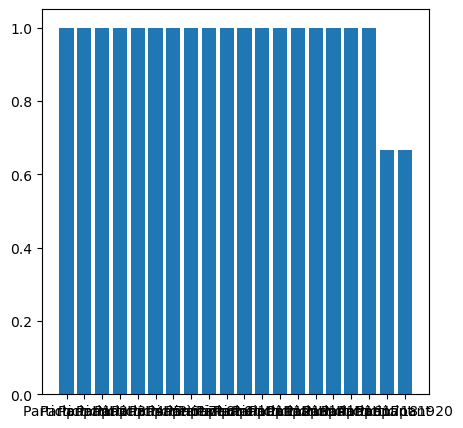

In [15]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(5, 5))
participant_labels = [f"Participant {i+1}" for i in range(len(corr_catch_per_participant))]
bars = ax.bar(participant_labels, corr_catch_per_participant)

Plot the cumulative catch performance over participants

Counter({1.0: 18, 0.67: 2})


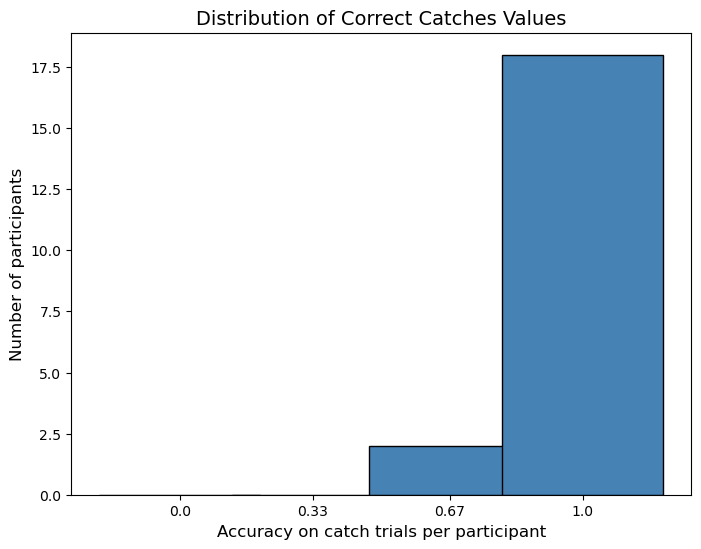

In [20]:
from collections import Counter
import matplotlib.pyplot as plt

# Round the values to 2 or 3 decimal places to match expected bins
rounded_values = [round(val, 2) for val in corr_catch_per_participant]

# Count rounded values
value_counts = Counter(rounded_values)
print(value_counts)

# Define the values we want to plot (rounded to 2 decimals)
values_to_plot = [0.0, 0.33, 0.67, 1.0]

# Get counts for each value
counts = [value_counts.get(val, 0) for val in values_to_plot]

# Create the barplot
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(values_to_plot, counts, width=0.4, color='steelblue', edgecolor='black')

ax.set_xlabel('Accuracy on catch trials per participant', fontsize=12)
ax.set_ylabel('Number of participants', fontsize=12)
ax.set_title('Distribution of Correct Catches Values', fontsize=14)
ax.set_xticks(values_to_plot)
ax.set_xticklabels(values_to_plot)

plt.show()


### Code beyond this was not really used

In [ ]:
# Calculate overall accuracy
human_accuracy = np.mean(H_responses_all) if H_responses_all else 0
ai_accuracy = np.mean(AI_responses_all) if AI_responses_all else 0

print(f"Overall Human identification accuracy: {human_accuracy:.4f}")
print(f"Overall AI identification accuracy: {ai_accuracy:.4f}")

# Calculate accuracy by conversation length
for length in len_list:
    h_acc = np.mean(H_responses_len[length]) if H_responses_len[length] else 0
    ai_acc = np.mean(AI_responses_len[length]) if AI_responses_len[length] else 0
    print(f"Length {length}: Human acc = {h_acc:.4f}, AI acc = {ai_acc:.4f}")

# Create confusion matrix
confusion_matrix = np.array([
    [human_accuracy, 1 - human_accuracy],
    [1 - ai_accuracy, ai_accuracy]
])

In [ ]:
# Plot the confusion matrix with better labels
plt.figure(figsize=(5, 5))
plt.imshow(confusion_matrix, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')

# Set axis labels
plt.ylabel('True Identity')
plt.xlabel('Label of Human Judge')

# Set custom tick labels
plt.yticks([0, 1], ['Actual Human', 'Actual AI'])
plt.xticks([0, 1], ['Labeled Human', 'Labeled AI'])

# Add text annotations
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{confusion_matrix[i, j]:.2f}', 
                 ha="center", va="center", color="white" if confusion_matrix[i, j] > 0.5 else "black",
                 fontsize=14)



In [ ]:
# Plot accuracy by conversation length
plt.figure(figsize=(10, 6))
h_acc_by_len = [np.mean(H_responses_len[l]) if H_responses_len[l] else 0 for l in len_list]
ai_acc_by_len = [np.mean(AI_responses_len[l]) if AI_responses_len[l] else 0 for l in len_list]

plt.plot(len_list, h_acc_by_len, 'o-', label='Human accuracy')
plt.plot(len_list, ai_acc_by_len, 's-', label='AI accuracy')
plt.xlabel('Conversation Length')
plt.ylabel('Accuracy')
plt.title('Identification Accuracy by Conversation Length')
plt.grid(True, alpha=0.3)
plt.legend()
#plt.savefig('accuracy_by_length.png')
#plt.close()

In [ ]:
# Feedback trials
H_responses_feedback = []
AI_responses_feedback = []
H_responses_len_feedback = {3: [], 6: [], 9: [], 12: [], 15: [], 18: [], 21: [], 24: []}
AI_responses_len_feedback = {3: [], 6: [], 9: [], 12: [], 15: [], 18: [], 21: [], 24: []}

H_inHH_responses_feedback = []
AI_inAIAI_responses_feedback = []
H_inHAI_responses_feedback = []
AI_inHAI_responses_feedback = []

# Non-feedback trials
H_responses_nofeedback = []
AI_responses_nofeedback = []
H_responses_len_nofeedback = {3: [], 6: [], 9: [], 12: [], 15: [], 18: [], 21: [], 24: []}
AI_responses_len_nofeedback = {3: [], 6: [], 9: [], 12: [], 15: [], 18: [], 21: [], 24: []}

H_inHH_responses_nofeedback = []
AI_inAIAI_responses_nofeedback = []
H_inHAI_responses_nofeedback = []
AI_inHAI_responses_nofeedback = []

# Combined (all trials)
H_responses_all = []
AI_responses_all = []
H_responses_len = {3: [], 6: [], 9: [], 12: [], 15: [], 18: [], 21: [], 24: []}
AI_responses_len = {3: [], 6: [], 9: [], 12: [], 15: [], 18: [], 21: [], 24: []}

H_inHH_responses_all = []
AI_inAIAI_responses_all = []
H_inHH_responses_len = {3: [], 6: [], 9: [], 12: [], 15: [], 18: [], 21: [], 24: []}
AI_inAIAI_responses_len = {3: [], 6: [], 9: [], 12: [], 15: [], 18: [], 21: [], 24: []}

H_inHAI_responses_all = []
AI_inHAI_responses_all = []
H_inHAI_responses_len = {3: [], 6: [], 9: [], 12: [], 15: [], 18: [], 21: [], 24: []}
AI_inHAI_responses_len = {3: [], 6: [], 9: [], 12: [], 15: [], 18: [], 21: [], 24: []}

# Initialize dictionary to store catch trial performance
catch_trial_performance = {}

# Process each participant
worker_accepted = 0
worker_rejected = 0
counter_good_workers = 0

# Track number of feedback and non-feedback trials
total_feedback_trials = 0
total_nofeedback_trials = 0

for index, worker in relevant_participants.iterrows():
    print(f"\n#### Worker {index} ####")
    
    try:
        # Parse the JSON datastring
        data = json.loads(worker["datastring"])
        
        # Extract worker demographic data
        Wgender = data['questiondata'].get('gender', 'Not specified')
        Wage = data['questiondata'].get('age', 'Not specified')
        Wlanguage = data['questiondata'].get('native', 'Not specified')
        Wdegree = data['questiondata'].get('education', 'Not specified')
        Wfield = data['questiondata'].get('country', 'Not specified')
        print(f"% W data {Wgender} {Wage} {Wlanguage} {Wdegree} {Wfield}")
        
        # Set threshold for accepting worker responses
        thr = 15
        corr = 0
        catch_corr = 0
        total_catch = 0
        
        # Find trial data entries
        trial_entries = [entry for entry in data['data'] if 
                         isinstance(entry.get('trialdata'), dict) and 
                         'hit' in entry.get('trialdata', {})]
        
        # First pass: count correct topic identifications and catch trials
        for c, entry in enumerate(trial_entries):
            trialdata = entry['trialdata']
            
            # Check if this is a catch trial
            is_catch = trialdata.get('isCatch', False)
            conv1_hit = trialdata.get('hit')
            
            # Also consider high hit IDs (301-305) as catch trials
            if is_catch or (conv1_hit and int(conv1_hit) > 300):
                total_catch += 1
                # Analyze catch trial correctness
                # For catch trials, assuming expected topic "3"
                conv1_topic = trialdata.get('topic')
                if conv1_topic == "3":
                    catch_corr += 1
                continue
            
            # For regular trials, check topic correctness
            conv1_topic = trialdata.get('topic')
            
            # Skip out-of-bounds hit IDs
            if not conv1_hit or int(conv1_hit) > len(hit_topic_label):
                continue
            
            # Check if topic is correct (only for regular trials)
            if conv1_topic and conv1_topic == str(hit_topic_label[int(conv1_hit)-1]):
                corr += 1
        
        # Store catch trial performance for this worker
        catch_trial_performance[index] = {
            'total': total_catch,
            'correct': catch_corr,
            'accuracy': catch_corr / total_catch if total_catch > 0 else 0
        }
        
        # Decide if worker meets quality thresholds (topic correctness AND catch trial performance)
        catch_threshold = 0.5  # At least 50% correct catch trials
        if corr >= thr and (total_catch == 0 or catch_corr / total_catch >= catch_threshold):
            worker_accepted += 1
            
            # Second pass: process each conversation trial for responses (skip catch trials)
            for c, entry in enumerate(trial_entries):
                trialdata = entry['trialdata']
                
                # Skip catch trials and non-standard entries
                is_catch = trialdata.get('isCatch', False)
                if not isinstance(trialdata, dict) or 'hit' not in trialdata:
                    continue
                
                # Get trial details
                conv1_hit = trialdata.get('hit')
                
                # Skip out-of-bounds hit IDs (catch trials 301-305)
                if not conv1_hit or int(conv1_hit) > len(conv_list_Alab) or int(conv1_hit) > len(hit_topic_label):
                    print(f"Skipping out-of-bounds hit ID: {conv1_hit}")
                    continue
                
                # Skip catch trials
                if is_catch:
                    continue
                
                conv1_len = trialdata.get('hit_len')
                conv1_combclass = trialdata.get('Aclass')
                conv1_topic = trialdata.get('topic')
                has_feedback = trialdata.get('hasFeedback', False)
                
                if not all([conv1_hit, conv1_len, conv1_combclass, conv1_topic]):
                    continue
                
                # Parse the combination class
                if conv1_combclass == 'HH':
                    conv1_Aclass = 'H'
                    conv1_Bclass = 'H'
                elif conv1_combclass == 'HAI':
                    conv1_Aclass = 'H'
                    conv1_Bclass = 'AI'
                elif conv1_combclass == 'AIH':
                    conv1_Aclass = 'AI'
                    conv1_Bclass = 'H'
                elif conv1_combclass == 'AIAI':
                    conv1_Aclass = 'AI'
                    conv1_Bclass = 'AI'
                else:
                    continue
                
                # Check if topic is correct
                hit_index = int(conv1_hit) - 1
                topic_correct = 'Keep' if conv1_topic == str(hit_topic_label[hit_index]) else 'Reject'
                print(f"{c} conv: {conv1_hit} {conv1_len} {conv1_Aclass} {conv1_Bclass} {conv1_topic} {topic_correct} Feedback: {has_feedback}")
                
                if topic_correct == 'Keep':
                    # Find the corresponding row in the results dataframe
                    row_indices = df_all_res[(df_all_res["hit id"] == int(conv1_hit)) & 
                                           (df_all_res["hit len"] == int(conv1_len))].index
                    
                    if len(row_indices) > 0:
                        row_index = row_indices[0]
                        rowidc.append(row_index)
                        
                        # Update responses in the dataframe
                        df_all_res.at[row_index, "Aresponse"].append(conv1_Aclass)
                        df_all_res.at[row_index, "Bresponse"].append(conv1_Bclass)
                        
                        # Track whether this is a feedback or non-feedback trial
                        if has_feedback:
                            total_feedback_trials += 1
                            h_responses = H_responses_feedback
                            ai_responses = AI_responses_feedback
                            h_responses_len = H_responses_len_feedback
                            ai_responses_len = AI_responses_len_feedback
                            
                            h_inhh_responses = H_inHH_responses_feedback
                            ai_inaiai_responses = AI_inAIAI_responses_feedback
                            h_inhai_responses = H_inHAI_responses_feedback
                            ai_inhai_responses = AI_inHAI_responses_feedback
                        else:
                            total_nofeedback_trials += 1
                            h_responses = H_responses_nofeedback
                            ai_responses = AI_responses_nofeedback
                            h_responses_len = H_responses_len_nofeedback
                            ai_responses_len = AI_responses_len_nofeedback
                            
                            h_inhh_responses = H_inHH_responses_nofeedback
                            ai_inaiai_responses = AI_inAIAI_responses_nofeedback
                            h_inhai_responses = H_inHAI_responses_nofeedback
                            ai_inhai_responses = AI_inHAI_responses_nofeedback
                        
                        # Process Speaker A classification
                        if conv_list_Alab[hit_index] == 'Human':
                            out = 1 if conv1_Aclass == 'H' else 0
                            h_responses.append(out)
                            h_responses_len[int(conv1_len)].append(out)
                            H_responses_all.append(out)
                            H_responses_len[int(conv1_len)].append(out)
                            
                            if conv_list_Blab[hit_index] == 'Human':
                                h_inhh_responses.append(out)
                                H_inHH_responses_all.append(out)
                                H_inHH_responses_len[int(conv1_len)].append(out)
                            else:
                                h_inhai_responses.append(out)
                                H_inHAI_responses_all.append(out)
                                H_inHAI_responses_len[int(conv1_len)].append(out)
                        
                        elif conv_list_Alab[hit_index] == 'AI':
                            out = 1 if conv1_Aclass == 'AI' else 0
                            ai_responses.append(out)
                            ai_responses_len[int(conv1_len)].append(out)
                            AI_responses_all.append(out)
                            AI_responses_len[int(conv1_len)].append(out)
                            
                            if conv_list_Blab[hit_index] == 'AI':
                                ai_inaiai_responses.append(out)
                                AI_inAIAI_responses_all.append(out)
                                AI_inAIAI_responses_len[int(conv1_len)].append(out)
                            else:
                                ai_inhai_responses.append(out)
                                AI_inHAI_responses_all.append(out)
                                AI_inHAI_responses_len[int(conv1_len)].append(out)
                        
                        # Process Speaker B classification
                        if conv_list_Blab[hit_index] == 'Human':
                            out = 1 if conv1_Bclass == 'H' else 0
                            h_responses.append(out)
                            h_responses_len[int(conv1_len)].append(out)
                            H_responses_all.append(out)
                            H_responses_len[int(conv1_len)].append(out)
                            
                            if conv_list_Alab[hit_index] == 'Human':
                                h_inhh_responses.append(out)
                                H_inHH_responses_all.append(out)
                                H_inHH_responses_len[int(conv1_len)].append(out)
                            else:
                                h_inhai_responses.append(out)
                                H_inHAI_responses_all.append(out)
                                H_inHAI_responses_len[int(conv1_len)].append(out)
                        
                        elif conv_list_Blab[hit_index] == 'AI':
                            out = 1 if conv1_Bclass == 'AI' else 0
                            ai_responses.append(out)
                            ai_responses_len[int(conv1_len)].append(out)
                            AI_responses_all.append(out)
                            AI_responses_len[int(conv1_len)].append(out)
                            
                            if conv_list_Alab[hit_index] == 'AI':
                                ai_inaiai_responses.append(out)
                                AI_inAIAI_responses_all.append(out)
                                AI_inAIAI_responses_len[int(conv1_len)].append(out)
                            else:
                                ai_inhai_responses.append(out)
                                AI_inHAI_responses_all.append(out)
                                AI_inHAI_responses_len[int(conv1_len)].append(out)
        else:
            reason = ""
            if corr < thr:
                reason += f"misclassified topics ({20-corr} errors), "
            if total_catch > 0 and catch_corr / total_catch < catch_threshold:
                reason += f"catch trial performance ({catch_corr}/{total_catch})"
            
            print(f"Worker excluded due to: {reason.strip(', ')}")
            worker_rejected += 1
    
    except Exception as e:
        print(f"Error processing worker data: {e}")
        import traceback
        traceback.print_exc()  # This will print the full stack trace
        worker_rejected += 1

print("==========================================")
print(f"Workers accepted: {worker_accepted}")
print(f"Workers rejected: {worker_rejected}")
print(f"Total feedback trials: {total_feedback_trials}")
print(f"Total non-feedback trials: {total_nofeedback_trials}")

In [ ]:
# Calculate catch trial performance stats
catch_acc_total = sum(perf['accuracy'] for perf in catch_trial_performance.values()) / len(catch_trial_performance) if catch_trial_performance else 0
print(f"Average catch trial accuracy: {catch_acc_total:.2f}")

# Calculate overall accuracy
human_accuracy = np.mean(H_responses_all) if H_responses_all else 0
ai_accuracy = np.mean(AI_responses_all) if AI_responses_all else 0

# Calculate accuracy for feedback trials
human_accuracy_feedback = np.mean(H_responses_feedback) if H_responses_feedback else 0
ai_accuracy_feedback = np.mean(AI_responses_feedback) if AI_responses_feedback else 0

# Calculate accuracy for non-feedback trials
human_accuracy_nofeedback = np.mean(H_responses_nofeedback) if H_responses_nofeedback else 0
ai_accuracy_nofeedback = np.mean(AI_responses_nofeedback) if AI_responses_nofeedback else 0

print(f"Overall Human identification accuracy: {human_accuracy:.4f}")
print(f"Overall AI identification accuracy: {ai_accuracy:.4f}")
print(f"Human accuracy (feedback trials): {human_accuracy_feedback:.4f}")
print(f"AI accuracy (feedback trials): {ai_accuracy_feedback:.4f}")
print(f"Human accuracy (non-feedback trials): {human_accuracy_nofeedback:.4f}")
print(f"AI accuracy (non-feedback trials): {ai_accuracy_nofeedback:.4f}")

In [ ]:
# Function to create and save a confusion matrix
def create_confusion_matrix(human_acc, ai_acc, title, filename):
    confusion_matrix = np.array([
        [human_acc, 1 - human_acc],
        [1 - ai_acc, ai_acc]
    ])
    
    plt.figure(figsize=(5, 5))
    plt.imshow(confusion_matrix, cmap='Blues')
    plt.colorbar()
    plt.title(title)
    
    # Set axis labels
    plt.ylabel('True Identity')
    plt.xlabel('Label of Human Judge')
    
    # Set custom tick labels
    plt.yticks([0, 1], ['Actual Human', 'Actual AI'])
    plt.xticks([0, 1], ['Labeled Human', 'Labeled AI'])
    
    # Add text annotations
    for i in range(2):
        for j in range(2):
            plt.text(j, i, f'{confusion_matrix[i, j]:.2f}', 
                     ha="center", va="center", color="white" if confusion_matrix[i, j] > 0.5 else "black",
                     fontsize=14)
    
    # Save the figure
    plt.tight_layout()
    #plt.savefig(filename, dpi=300)
    #plt.close()

In [ ]:
# Create the three confusion matrices
create_confusion_matrix(human_accuracy, ai_accuracy, 
                       'Confusion Matrix - All Trials', 
                       'confusion_matrix_all.png')

create_confusion_matrix(human_accuracy_feedback, ai_accuracy_feedback, 
                       'Confusion Matrix - Feedback Trials', 
                       'confusion_matrix_feedback.png')

create_confusion_matrix(human_accuracy_nofeedback, ai_accuracy_nofeedback, 
                       'Confusion Matrix - Non-Feedback Trials', 
                       'confusion_matrix_nofeedback.png')

In [ ]:
# Add this to your existing code

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Create a function to analyze worker-wise progression
def analyze_worker_progression(relevant_participants, conv_list_Alab, conv_list_Blab, hit_topic_label):
    # Dictionary to store each worker's performance over trials
    worker_progression = {}
    
    for index, worker in relevant_participants.iterrows():
        try:
            # Parse the JSON datastring
            data = json.loads(worker["datastring"])
            
            # Skip workers with missing data
            if 'data' not in data:
                continue
                
            # Find trial data entries and sort by trial number
            trial_entries = [entry for entry in data['data'] if 
                            isinstance(entry.get('trialdata'), dict) and 
                            'hit' in entry.get('trialdata', {})]
            
            # Sort by trial number if available
            trial_entries.sort(key=lambda x: x.get('trialdata', {}).get('trial', 0))
            
            # Initialize arrays to track performance
            correctness = []
            has_feedback_list = []
            trial_numbers = []
            trial_types = []  # H-H, H-AI, AI-H, AI-AI
            
            for trial_num, entry in enumerate(trial_entries):
                trialdata = entry['trialdata']
                
                # Skip catch trials
                is_catch = trialdata.get('isCatch', False)
                conv1_hit = trialdata.get('hit')
                if is_catch or (conv1_hit and int(conv1_hit) > 300):
                    continue
                
                # Skip trials with missing data
                if not all([trialdata.get(field) for field in ['hit', 'hit_len', 'Aclass', 'topic']]):
                    continue
                
                # Get trial details
                conv1_hit = int(trialdata.get('hit'))
                
                # Skip out-of-bounds hit IDs
                if conv1_hit > len(conv_list_Alab) or conv1_hit > len(hit_topic_label):
                    continue
                
                conv1_combclass = trialdata.get('Aclass')
                has_feedback = trialdata.get('hasFeedback', False)
                
                # Parse the combination class
                if conv1_combclass == 'HH':
                    conv1_Aclass = 'H'
                    conv1_Bclass = 'H'
                    trial_type = 'H-H'
                elif conv1_combclass == 'HAI':
                    conv1_Aclass = 'H'
                    conv1_Bclass = 'AI'
                    trial_type = 'H-AI'
                elif conv1_combclass == 'AIH':
                    conv1_Aclass = 'AI'
                    conv1_Bclass = 'H'
                    trial_type = 'AI-H'
                elif conv1_combclass == 'AIAI':
                    conv1_Aclass = 'AI'
                    conv1_Bclass = 'AI'
                    trial_type = 'AI-AI'
                else:
                    continue
                
                hit_index = conv1_hit - 1
                
                # Calculate correctness (1 for both correct, 0.5 for one correct, 0 for none correct)
                correct_A = (conv1_Aclass == 'H' and conv_list_Alab[hit_index] == 'Human') or \
                           (conv1_Aclass == 'AI' and conv_list_Alab[hit_index] == 'AI')
                correct_B = (conv1_Bclass == 'H' and conv_list_Blab[hit_index] == 'Human') or \
                           (conv1_Bclass == 'AI' and conv_list_Blab[hit_index] == 'AI')
                
                score = (correct_A + correct_B) / 2.0  # 0, 0.5, or 1
                
                correctness.append(score)
                has_feedback_list.append(has_feedback)
                trial_numbers.append(trial_num)
                trial_types.append(trial_type)
            
            # Store worker's progression data
            if correctness:  # Only store if we have valid trials
                worker_progression[index] = {
                    'correctness': correctness,
                    'has_feedback': has_feedback_list,
                    'trial_numbers': trial_numbers,
                    'trial_types': trial_types
                }
                
        except Exception as e:
            print(f"Error processing worker {index} for progression analysis: {e}")
    
    return worker_progression

# Analyze worker progression
worker_progression = analyze_worker_progression(relevant_participants, conv_list_Alab, conv_list_Blab, hit_topic_label)

# Plot worker progression heatmap
def plot_worker_progression(worker_progression):
    if not worker_progression:
        print("No worker progression data available for plotting")
        return
    
    # Find the maximum number of trials across all workers
    max_trials = max([len(data['correctness']) for data in worker_progression.values()])
    
    # Create matrix to hold correctness data
    # Rows = workers, Columns = trials
    worker_ids = list(worker_progression.keys())
    correctness_matrix = np.full((len(worker_ids), max_trials), np.nan)
    feedback_matrix = np.zeros((len(worker_ids), max_trials))
    
    # Fill in the matrices
    for i, worker_id in enumerate(worker_ids):
        data = worker_progression[worker_id]
        for j, (correct, has_feedback) in enumerate(zip(data['correctness'], data['has_feedback'])):
            correctness_matrix[i, j] = correct
            feedback_matrix[i, j] = 1 if has_feedback else 0
    
    # Create main figure
    plt.figure(figsize=(14, 10))
    
    # Create custom colormap for correctness (red-yellow-green)
    cmap = plt.cm.plasma
    
    # Plot correctness matrix
    ax = plt.subplot(111)
    im = ax.imshow(correctness_matrix, cmap=cmap, vmin=0, vmax=1)
    
    # Highlight feedback trials with a hatch pattern
    for i in range(len(worker_ids)):
        for j in range(max_trials):
            if not np.isnan(correctness_matrix[i, j]):
                if feedback_matrix[i, j] > 0:
                    # Add black border around feedback trial cells
                    rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor='black', linewidth=1)
                    ax.add_patch(rect)
    
    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.set_label('Correctness (0 = both wrong, 0.5 = one correct, 1 = both correct)')
    
    # Set title and labels
    plt.title('Worker Performance Progression Across Trials')
    plt.xlabel('Trial Number')
    plt.ylabel('Worker ID')
    
    # Set tick labels
    plt.yticks(range(len(worker_ids)), worker_ids)
    plt.xticks(range(max_trials), range(1, max_trials+1))
    
    # Add legend for feedback trials
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='white', edgecolor='black', label='Feedback Trial'),
        Patch(facecolor='white', edgecolor='none', label='No Feedback Trial')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    #plt.savefig('worker_progression_heatmap.png', dpi=300)
    #plt.close()

    # Also create a line plot showing average performance over trials
    plt.figure(figsize=(12, 6))
    
    # Calculate average correctness for each trial, separately for feedback and no feedback
    avg_correctness = np.nanmean(correctness_matrix, axis=0)
    
    # Split by feedback vs no feedback
    feedback_trials = np.where(np.sum(feedback_matrix, axis=0) > 0)[0]
    nofeedback_trials = np.where(np.sum(feedback_matrix, axis=0) == 0)[0]
    
    # Find the transition point from feedback to no feedback
    if len(feedback_trials) > 0 and len(nofeedback_trials) > 0:
        transition_point = max(feedback_trials) + 0.5
    else:
        transition_point = None
    
    # Plot average correctness
    plt.plot(range(1, len(avg_correctness)+1), avg_correctness, 'o-', label='Average Performance', color='blue')
    
    # Shade the feedback and non-feedback regions
    if transition_point:
        plt.axvspan(0.5, transition_point, alpha=0.2, color='green', label='Feedback Region')
        plt.axvspan(transition_point, max_trials+0.5, alpha=0.2, color='red', label='No Feedback Region')
    
    plt.xlabel('Trial Number')
    plt.ylabel('Average Correctness')
    plt.title('Average Worker Performance Over Trials')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(0, 1)
    plt.tight_layout()
   #plt.savefig('worker_progression_average.png', dpi=300)
    #plt.close()
    
    # Create a separate plot for trial types (H-H, H-AI, AI-H, AI-AI)
    trial_type_counts = {}
    trial_type_correctness = {}
    
    for worker_id, data in worker_progression.items():
        for trial_num, (trial_type, correctness) in enumerate(zip(data['trial_types'], data['correctness'])):
            if trial_num not in trial_type_counts:
                trial_type_counts[trial_num] = {'H-H': 0, 'H-AI': 0, 'AI-H': 0, 'AI-AI': 0}
                trial_type_correctness[trial_num] = {'H-H': [], 'H-AI': [], 'AI-H': [], 'AI-AI': []}
            
            trial_type_counts[trial_num][trial_type] += 1
            trial_type_correctness[trial_num][trial_type].append(correctness)
    
    # Calculate average correctness by trial type
    trial_nums = sorted(trial_type_counts.keys())
    
    plt.figure(figsize=(12, 6))
    
    for trial_type in ['H-H', 'H-AI', 'AI-H', 'AI-AI']:
        avg_correctness = []
        for trial_num in trial_nums:
            if trial_type_counts[trial_num][trial_type] > 0:
                avg = np.mean(trial_type_correctness[trial_num][trial_type])
            else:
                avg = np.nan
            avg_correctness.append(avg)
        
        plt.plot(np.array(trial_nums) + 1, avg_correctness, 'o-', label=f'{trial_type}')
    
    # Shade the feedback and non-feedback regions
    if transition_point:
        plt.axvspan(0.5, transition_point, alpha=0.2, color='green', label='Feedback Region')
        plt.axvspan(transition_point, max(trial_nums)+1.5, alpha=0.2, color='red', label='No Feedback Region')
    
    plt.xlabel('Trial Number')
    plt.ylabel('Average Correctness')
    plt.title('Performance by Conversation Type Over Trials')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(0, 1)
    plt.tight_layout()
    #plt.savefig('worker_progression_by_type.png', dpi=300)
    #plt.close()


# Call the function to generate the plots
plot_worker_progression(worker_progression)

In [ ]:
636+642